# Emotion Dataset — EDA & Preprocessing Checks

This notebook inspects split sizes and class balance, validates image paths, and previews a few images.


In [1]:
import os
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
# Paths (adjust if your files live elsewhere)
CSV_TRAIN = r"C:\Users\ASUS\Documents\ann-visual-emotion\data\processed\EmoSet_splits\train.csv"
CSV_VAL   = r"C:\Users\ASUS\Documents\ann-visual-emotion\data\processed\EmoSet_splits\val.csv"
CSV_TEST  = r"C:\Users\ASUS\Documents\ann-visual-emotion\data\processed\EmoSet_splits\test.csv"
LABEL_MAP_JSON = r"C:\Users\ASUS\Documents\ann-visual-emotion\data\processed\EmoSet_splits\label_map.json"
STATS_JSON     = r"C:\Users\ASUS\Documents\ann-visual-emotion\data\processed\EmoSet_splits\stats.json"
assert os.path.exists(CSV_TRAIN), f"Missing {CSV_TRAIN}"
assert os.path.exists(CSV_VAL),   f"Missing {CSV_VAL}"
assert os.path.exists(CSV_TEST),  f"Missing {CSV_TEST}"

In [3]:
train_df = pd.read_csv(CSV_TRAIN)
val_df   = pd.read_csv(CSV_VAL)
test_df  = pd.read_csv(CSV_TEST)

In [4]:
display(train_df.head())
display(val_df.head())
display(test_df.head())

,image_path,label
0,data/raw/EmoSet/contentment/contentment_09260.jpg,contentment
1,data/raw/EmoSet/anger/anger_06224.jpg,anger
2,data/raw/EmoSet/contentment/contentment_03550.jpg,contentment
3,data/raw/EmoSet/sadness/sadness_08827.jpg,sadness
4,data/raw/EmoSet/contentment/contentment_09558.jpg,contentment


,image_path,label
0,data/raw/EmoSet/amusement/amusement_03323.jpg,amusement
1,data/raw/EmoSet/contentment/contentment_01769.jpg,contentment
2,data/raw/EmoSet/excitement/excitement_19925.jpg,excitement
3,data/raw/EmoSet/amusement/amusement_05206.jpg,amusement
4,data/raw/EmoSet/contentment/contentment_09125.jpg,contentment


,image_path,label
0,data/raw/EmoSet/excitement/excitement_02484.jpg,excitement
1,data/raw/EmoSet/amusement/amusement_18998.jpg,amusement
2,data/raw/EmoSet/excitement/excitement_02958.jpg,excitement
3,data/raw/EmoSet/excitement/excitement_00670.jpg,excitement
4,data/raw/EmoSet/excitement/excitement_02275.jpg,excitement


## Split sizes


In [5]:
sizes = {
    "train": len(train_df),
    "val":   len(val_df),
    "test":  len(test_df),
}
sizes

{'train': 13864, 'val': 1734, 'test': 1734}

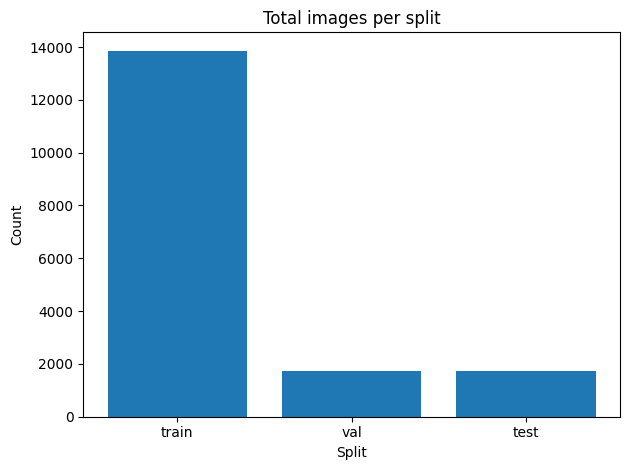

In [6]:
# Bar: total per split (matplotlib only, one figure per chart, no styles/colors set)
plt.figure()
plt.bar(list(sizes.keys()), list(sizes.values()))
plt.title("Total images per split")
plt.xlabel("Split")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Class distribution per split


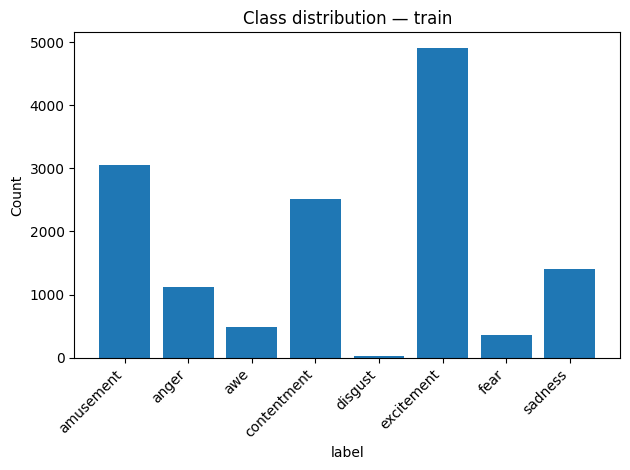

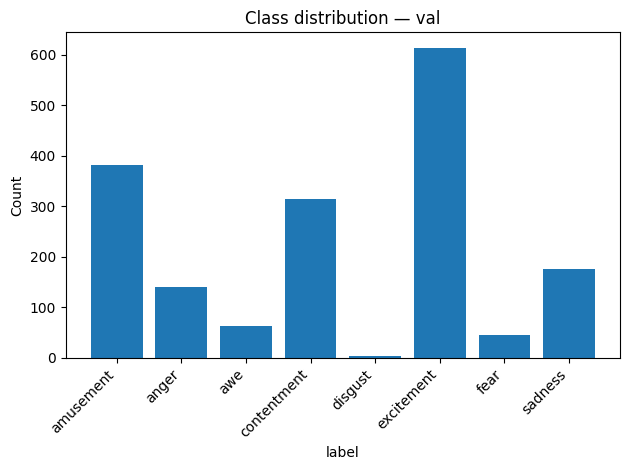

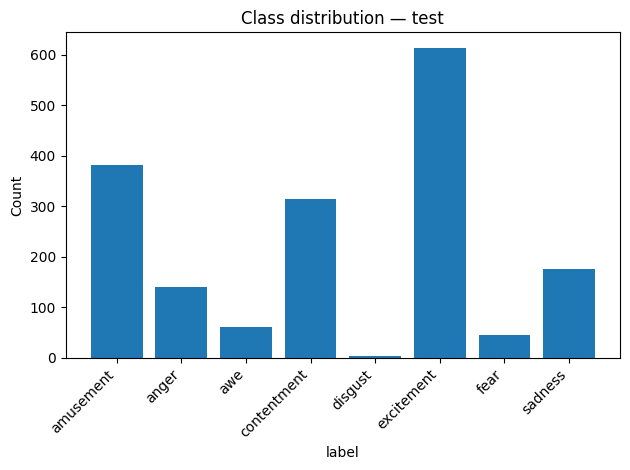

In [7]:
def plot_class_dist(df, split_name):
    vc = df['label'].value_counts().sort_index()
    plt.figure()
    plt.bar(vc.index.tolist(), vc.values.tolist())
    plt.title(f"Class distribution — {split_name}")
    plt.xlabel("label")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_class_dist(train_df, "train")
plot_class_dist(val_df, "val")
plot_class_dist(test_df, "test")


In [10]:
# Statistic analysis
import json

with open(STATS_JSON) as f:
    stats = json.load(f)

# Build dataframe from stats.json
rows = []
for split, info in stats["splits"].items():
    for lab, cnt in info["by_label"].items():
        rows.append({"split": split, "label": lab, "count": cnt})

df = pd.DataFrame(rows)

In [11]:
# Overall counts
global_counts = df.groupby("label")["count"].sum().sort_values(ascending=False)
print("Total per class:\n", global_counts)

Total per class:
 label
excitement     6138
amusement      3808
contentment    3140
sadness        1754
anger          1399
awe             614
fear            452
disgust          27
Name: count, dtype: int64


In [12]:
# Percentages
total = global_counts.sum()
print("\nPercentage per class:")
print((global_counts / total * 100).round(2))


Percentage per class:
label
excitement     35.41
amusement      21.97
contentment    18.12
sadness        10.12
anger           8.07
awe             3.54
fear            2.61
disgust         0.16
Name: count, dtype: float64


In [13]:
# Summary stats
print("\nDescriptive statistics:")
print(global_counts.describe())


Descriptive statistics:
count       8.000000
mean     2166.500000
std      2073.694977
min        27.000000
25%       573.500000
50%      1576.500000
75%      3307.000000
max      6138.000000
Name: count, dtype: float64
